In [2]:
#!git clone https://github.com/opendp/smartnoise-sdk

Cloning into 'smartnoise-sdk'...
remote: Enumerating objects: 6776, done.
remote: Counting objects: 100% (2074/2074), done.
remote: Compressing objects: 100% (1262/1262), done.
remote: Total 6776 (delta 1094), reused 1528 (delta 716), pack-reused 4702
Receiving objects: 100% (6776/6776), 37.35 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (3902/3902), done.


In [3]:
#!git clone https://github.com/IBM/differential-privacy-library

Cloning into 'differential-privacy-library'...
remote: Enumerating objects: 3964, done.
remote: Counting objects: 100% (914/914), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 3964 (delta 664), reused 560 (delta 408), pack-reused 3050
Receiving objects: 100% (3964/3964), 1.94 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (2895/2895), done.


In [1]:
pip install --editable smartnoise-sdk/synth

Obtaining file:///home/ec2-user/SageMaker/Utils_Update_11_26/smartnoise-sdk/synth
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 21.5 MB 30.7 MB/s eta 0:00:01    |████████▉                       | 5.9 MB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 67.9 MB/s eta 0:00:01
     |████████████████████████████████| 23.3 MB 18.5 MB/s eta 0:00:01
     |████████████████████████████████| 881.9 MB 9.0 kB/s  eta 0:00:01
     |████████████████████████████████| 9.5 MB 51.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
  Running setup.py develop for smartnoise-synth
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel

In [1]:
#pip install --editable differential-privacy-library

In [2]:
!pip install diffprivlib

     |████████████████████████████████| 87 kB 8.0 MB/s  eta 0:00:01
  Created wheel for diffprivlib: filename=diffprivlib-0.5.0-py3-none-any.whl size=162302 sha256=1b7e7e879278498ecf45cf3bd1651c2dd89ce5ec51024ac106223712e2b64718
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e3/06/66/53eecc576e61a914f03ad5caee627823eb857225cb84aeb6d2
Successfully built diffprivlib
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from utils import convert_to_cat
from utils import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from utils import get_classification_summary, get_table_metrics, get_epsilon_plots
from utils import dp_model_classification_helper, get_dp_model_table_metrics

In [2]:
#pip show diffprivlib

In [3]:
import warnings
warnings.filterwarnings('ignore')

### 1. Convert all columns to categorical

In [4]:
# Read in sample directly
adult_data = pd.read_csv('acs_income_data_sample.csv', index_col=False)

In [5]:
adult_data.head()

,Unnamed: 0,label,race,sex,hours_week,native_country,occupation,marital,education,workclass,age,relationship
0,806757,>50K,White alone,Female,40.0,27.0,CMS,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Reference person
1,296415,<=50K,White alone,Female,25.0,8.0,EAT,Married,Regular high school diploma,Employee of a private for-profit company or bu...,19.0,Biological son or daughter
2,717607,<=50K,White alone,Female,20.0,216.0,OFF,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Husband/wife
3,1574145,<=50K,White alone,Female,25.0,53.0,SAL,Divorced,Regular high school diploma,Employee of a private for-profit company or bu...,56.0,Reference person
4,765750,<=50K,Black or African American alone,Male,40.0,26.0,HLS,Never married,Regular high school diploma,Employee of a private for-profit company or bu...,25.0,Biological son or daughter


In [6]:
# Get the processed acs income data
processed_adult = convert_to_cat(adult_data, dataset="acs")
processed_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,1,0,1,1
2,0,0,0,1,2,0,0,0,0,2
3,0,0,0,1,3,1,1,0,2,0
4,0,1,1,0,4,2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,0,19,1,5,0,4,4
29996,1,0,0,0,17,0,0,0,0,0
29997,1,0,0,1,7,0,5,2,4,2
29998,0,0,1,0,17,2,4,4,3,11


In [7]:
# Print out dtype of all columns
print(processed_adult.dtypes)

label           int64
race            int64
sex             int64
hours_week      int64
occupation      int64
marital         int64
education       int64
workclass       int64
age             int64
relationship    int64
dtype: object


In [8]:
# Split processed data into train and test
processed_train, processed_test = train_test_split(processed_adult, test_size=0.2, random_state=0)

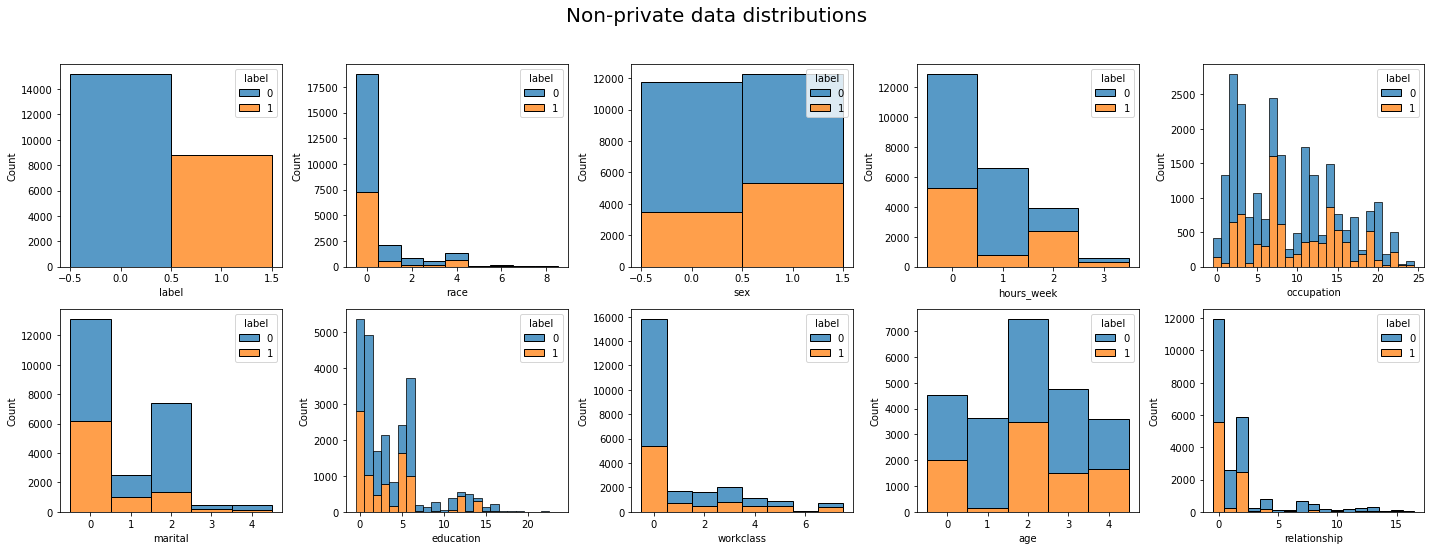

In [9]:
# Plot the non-private distributions
plot_distributions(processed_train, dataset = "acs", title="Non-private data distributions")

### 2. Train binary classifier on non-private data

In [10]:
y_train_pred, y_test_pred = get_classification_summary(processed_train, processed_test, dataset= "acs", classifier="logistic")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.0719, Male: 0.6329

False positive rates:
Female: 0.0371, Male: 0.2772

Equalized odds distances:
y=1: 0.5610, y=0: 0.2401

Classification accuracies:
Female: 0.6910, Male: 0.6842

F1-score: 0.4934

Avg train pred: 0.2448, Avg test pred: 0.2470


### 3. New MWEM synthesis

In [12]:
# Set range of epsilon vals
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with MWEM
#save_synthetic_data(epsilon_vals, processed_train, synthesizer="MWEM", dataset = "acs", n_reps=10)


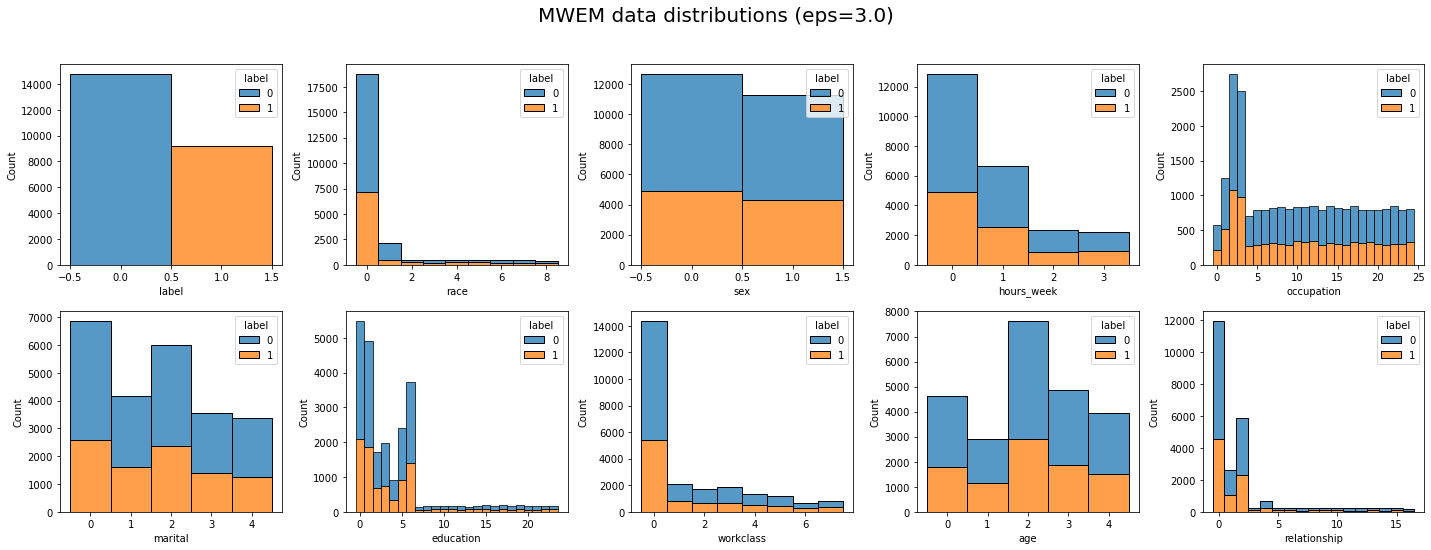

In [11]:
MWEM_eps3_rep0 = pd.read_csv("MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset = "acs")

In [12]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=processed_test, dataset = "acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.001
F1-score median: 0.000


In [13]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=processed_test, dataset = "acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.004
FPR difference median: -0.025
F1-score median: 0.312


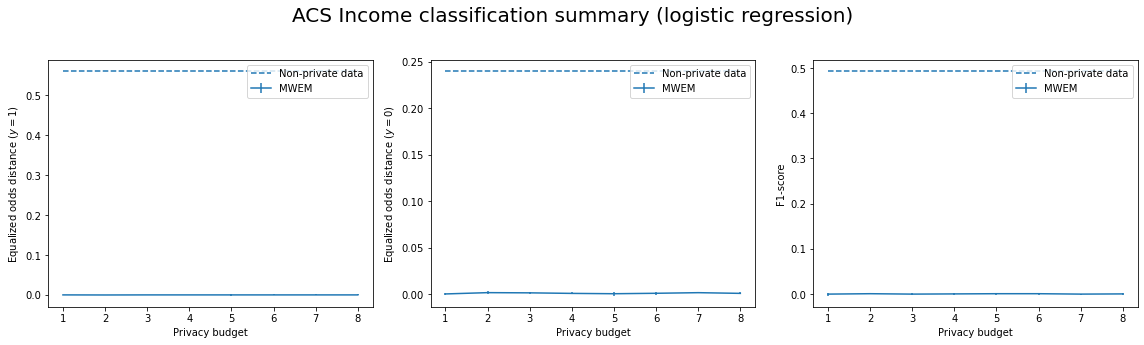

In [16]:
get_epsilon_plots(synthesizer_list=['MWEM'], epsilon_list=epsilon_vals, nreps=10, classifier="logistic", test_df=processed_test, f1_metric="median", non_priv_train=processed_train, dataset="acs")

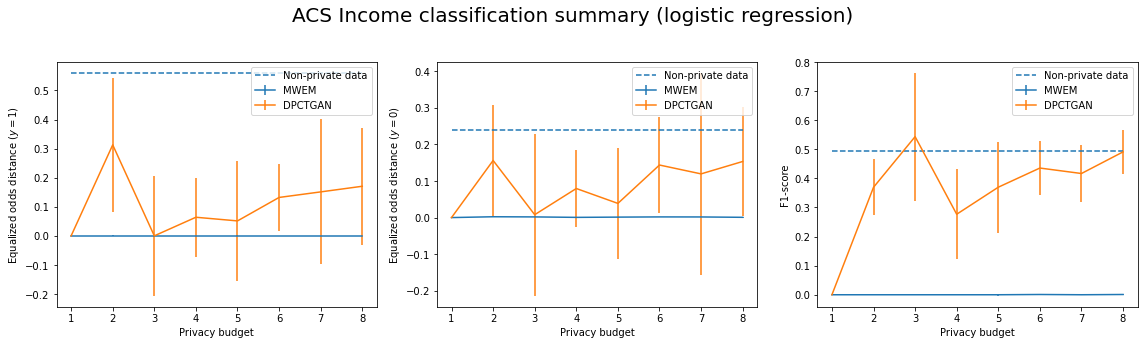

In [15]:
get_epsilon_plots(synthesizer_list=['MWEM', 'DPCTGAN'], epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test, f1_metric="median", non_priv_train=processed_train, dataset="acs")

### 4. New DPCTGAN Synthesis

In [ ]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with DP-CTGAN 
#save_synthetic_data(epsilon_vals, processed_train, synthesizer="DPCTGAN", dataset = "acs", n_reps=5)

Epoch 1, Loss G: 0.6432, Loss D: 1.3906
epsilon is 0.16118641571168127, alpha is 63.0
Epoch 2, Loss G: 0.6410, Loss D: 1.3955
epsilon is 0.21771147579290234, alpha is 63.0
Epoch 3, Loss G: 0.6508, Loss D: 1.3889
epsilon is 0.27423653587412344, alpha is 63.0
Epoch 4, Loss G: 0.6573, Loss D: 1.3856
epsilon is 0.33076159595534455, alpha is 63.0
Epoch 5, Loss G: 0.6503, Loss D: 1.3942
epsilon is 0.38354658916530343, alpha is 55.0
Epoch 6, Loss G: 0.6603, Loss D: 1.3799
epsilon is 0.43036359337843194, alpha is 50.0
Epoch 7, Loss G: 0.6498, Loss D: 1.3868
epsilon is 0.4729582167639962, alpha is 46.0
Epoch 8, Loss G: 0.6443, Loss D: 1.3942
epsilon is 0.5123193729642015, alpha is 43.0
Epoch 9, Loss G: 0.6546, Loss D: 1.3857
epsilon is 0.5491525595470659, alpha is 41.0
Epoch 10, Loss G: 0.6558, Loss D: 1.3891
epsilon is 0.5838792273158366, alpha is 38.0
Epoch 11, Loss G: 0.6536, Loss D: 1.3866
epsilon is 0.6167876297286142, alpha is 37.0
Epoch 12, Loss G: 0.6454, Loss D: 1.3909
epsilon is 0.648

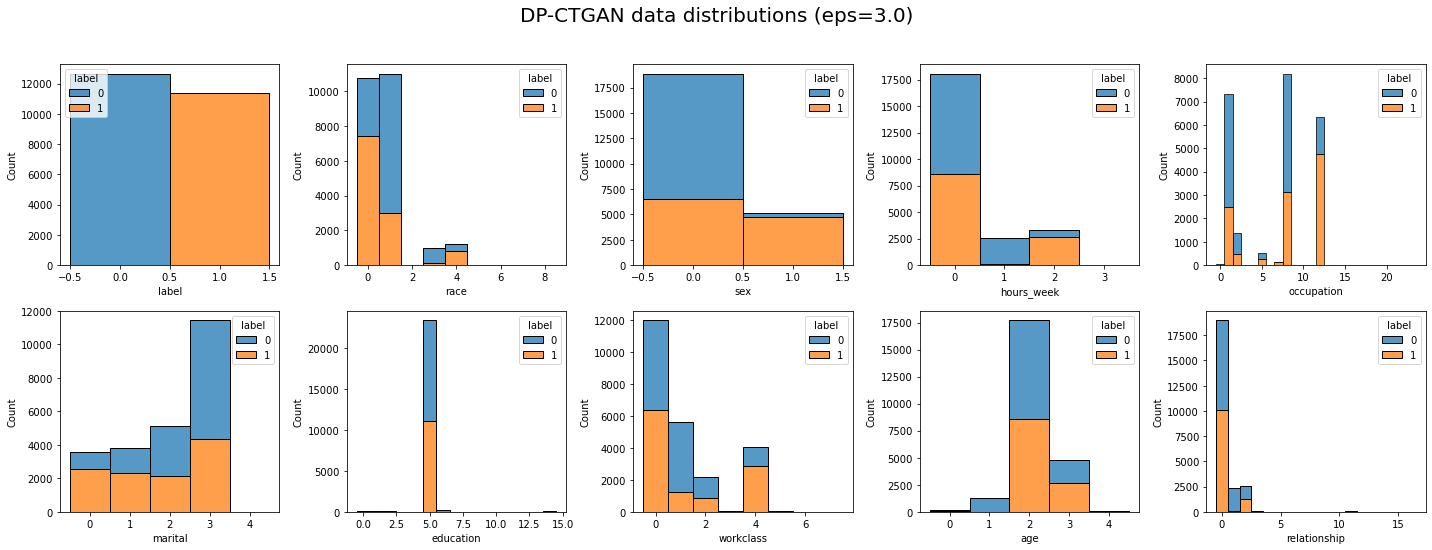

In [ ]:
DPCTGAN_eps3_rep0 = pd.read_csv("DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset = "acs")

In [ ]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=5, classifier="logistic", test_df=processed_test, dataset = "acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.008
F1-score median: 0.543


In [ ]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=5, classifier="forest", test_df=processed_test, dataset = "acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.042
FPR difference median: 0.046
F1-score median: 0.568


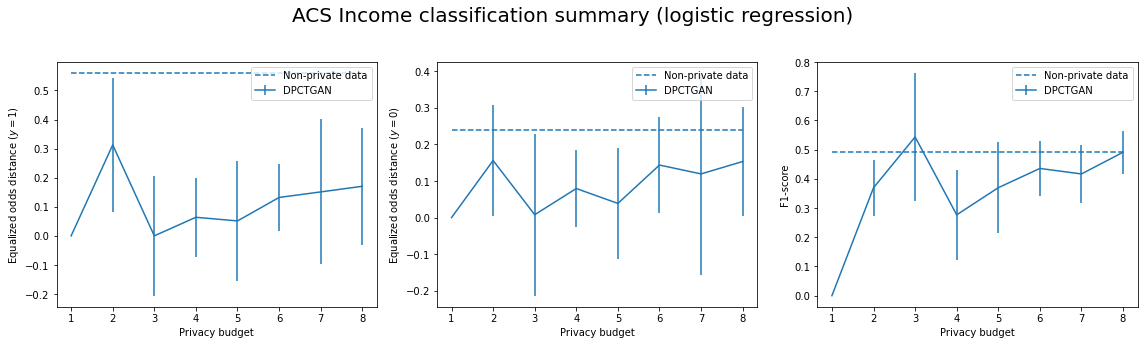

In [17]:
# Plot new DP-CTGAN results at range of epsilon values
get_epsilon_plots(["DPCTGAN"], epsilon_vals, 5, "logistic", processed_test, "median", processed_train, dataset="acs")

### 5. New PATE-CTGAN synthesis

In [20]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with DP-PATECTGAN
#save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=10, dataset = "acs")

Completed eps=1.0, rep=1.
Completed eps=1.0, rep=2.
Completed eps=1.0, rep=3.
Completed eps=1.0, rep=4.
Completed eps=1.0, rep=5.
Completed eps=1.0, rep=6.
Completed eps=1.0, rep=7.
Completed eps=1.0, rep=8.
Completed eps=1.0, rep=9.
Completed eps=1.0, rep=10.
Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed

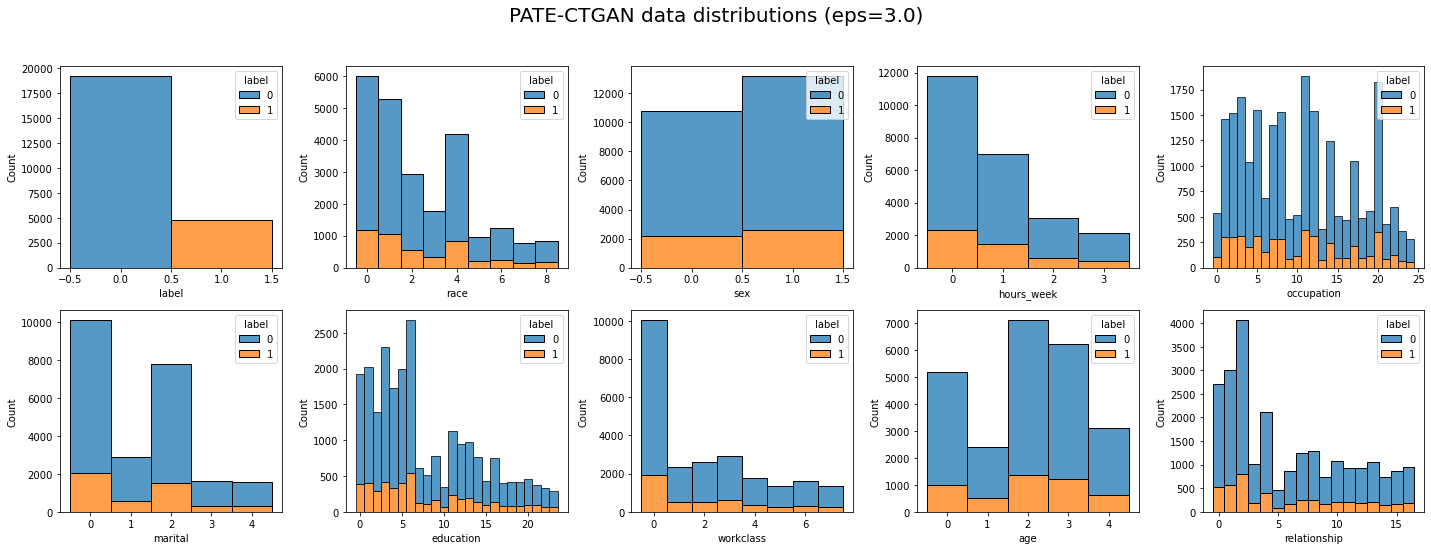

In [21]:
PATECTGAN_eps3_rep0 = pd.read_csv("PATECTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep0, title="PATE-CTGAN data distributions (eps=3.0)", dataset = "acs")

In [22]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=processed_test, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [23]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=processed_test, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.004
FPR difference median: 0.001
F1-score median: 0.029


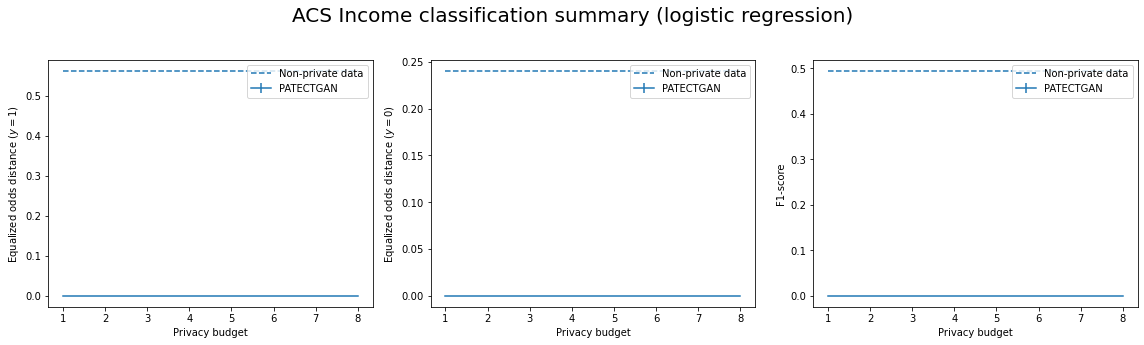

In [18]:
# Plot new DP-CTGAN results at range of epsilon values
get_epsilon_plots(["PATECTGAN"], epsilon_vals, 10, "logistic", processed_test, "median", processed_train, dataset="acs")

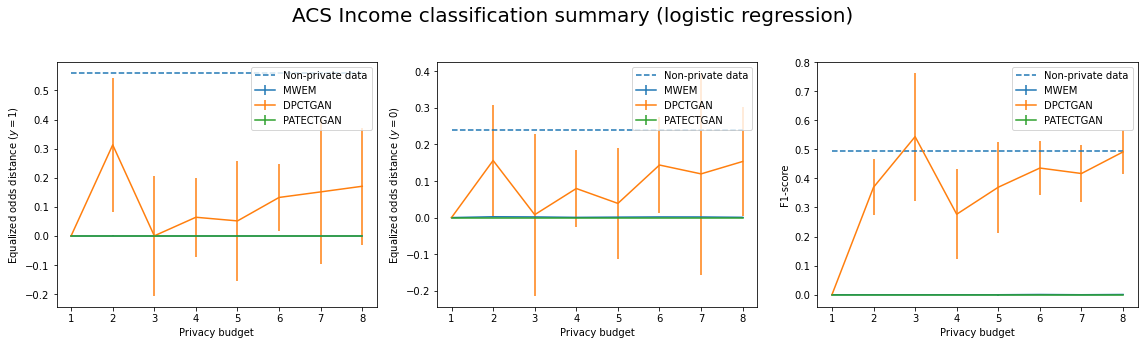

In [19]:
# Plot all 3 without QUAIL
get_epsilon_plots(["MWEM", "DPCTGAN","PATECTGAN"], epsilon_vals, 5, "logistic", processed_test, "median", processed_train, dataset="acs")

### 6. New MWEM with QUAIL

### 7. New DPCTGAN with QUAIL

### 8. New PATECTGAN with QUAIL